## Dataset: Anti Money Laundering Transaction Data (SAML-D)

Este projeto utiliza o **SAML-D (Synthetic Anti-Money Laundering Dataset)**, um conjunto de dados sintético desenvolvido para apoiar pesquisas em detecção de lavagem de dinheiro. O dataset contém **9.5 milhões de transações**, das quais aproximadamente **0.1% são suspeitas**, distribuídas em **28 tipologias** (11 normais e 17 suspeitas). As transações incluem **12 atributos principais**, como data, contas de origem/destino, valor, tipo e localização do pagamento, moeda e um indicador binário de suspeita. Além disso, o SAML-D fornece **15 estruturas gráficas de rede** representando o fluxo de transações entre contas, aumentando a complexidade e permitindo estudos com métodos baseados em grafos.  

Este é também o propósito deste projeto: **utilizar grafos como entrada para um foundation model que gere embeddings independentes da estrutura do grafo na área financeira**. Inicialmente, o foco será em **grafos de transações financeiras**, avaliando a qualidade dos embeddings por meio de uma baseline de **detecção de fraude**.  

> **Referência**:  
> B. Oztas, D. Cetinkaya, F. Adedoyin, M. Budka, H. Dogan and G. Aksu,  
> *"Enhancing Anti-Money Laundering: Development of a Synthetic Transaction Monitoring Dataset,"*  
> 2023 IEEE International Conference on e-Business Engineering (ICEBE), Sydney, Australia, 2023, pp. 47-54.  
> DOI: [10.1109/ICEBE59045.2023.00028](https://doi.org/10.1109/ICEBE59045.2023.00028)  


### Setup

In [54]:
import kagglehub
import os, gc, math, json, warnings
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import networkx as nx

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True
warnings.filterwarnings('ignore')

CSV_PATH = kagglehub.dataset_download("berkanoztas/synthetic-transaction-monitoring-dataset-aml")
path = Path(CSV_PATH)

Using Colab cache for faster access to the 'synthetic-transaction-monitoring-dataset-aml' dataset.


In [24]:
print("Arquivos disponíveis:", list(path.iterdir()))
csv_file = Path(CSV_PATH) / "SAML-D.csv"

Arquivos disponíveis: [PosixPath('/kaggle/input/synthetic-transaction-monitoring-dataset-aml/SAML-D.csv')]


### Carregamento e normalização

In [25]:
assert Path(path).exists(), f"CSV não encontrado em {path}. Ajuste a variável CSV_PATH."
df = pd.read_csv(path)
print("Dimensão inicial:", df.shape)
print("Colunas:", list(df.columns))

Dimensão inicial: (9504852, 12)
Colunas: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type']


In [26]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [28]:
#juntar date e time em uma nova coluna
df['ts'] = pd.to_datetime(df['Date'].astype(str)+' '+df['Time'].astype(str), errors='coerce')
df['ts'].head()

,ts
0,2022-10-07 10:35:19
1,2022-10-07 10:35:20
2,2022-10-07 10:35:20
3,2022-10-07 10:35:21
4,2022-10-07 10:35:21


A limpeza abaixo foi feita pensando em evitar duplicação de categorias, como por exemplo **["usd", "USD", ...] -> "USD"**.



In [30]:
#remover espaços, usar maiusculas em moedas e localizações, normalizar payment_type (por enquanto só removendo espaços)
for c in ['Payment_currency','Received_currency','Sender_bank_location','Receiver_bank_location']:
    df[c] = df[c].str.strip().str.upper()

df['Payment_type'] = df['Payment_type'].str.strip()

Acrescentei duas features para auxiliar o modelo a detectar padrões que indicam risco e como uma forma de enriquecer os atributos das arestas do grafo que será montado.

- A primeira, *currency_mismatch*, recebe o valor 1 caso a moeda de pagamento seja diferenta da moeda recebida. Em esquemas fraudulentos é comum ter essa conversão de moeda como uma tentaiva de quebrar o rastro do dinheiro.

- A segunda, *cross_border*, recebe o valor 1 se o banco remetente está em um país diferente do banco recebedor. Nesse caso, transações internacionais aumentam risco, proque dificultam fiscalização e podem servir para explorar brechas regulatórias.

In [31]:
df['currency_mismatch'] = (df['Payment_currency']!=df['Received_currency']).astype('int8')
df['cross_border'] = (df['Sender_bank_location']!=df['Receiver_bank_location']).astype('int8')

Abaixo são criados atributos de aresta temporais que permitem detectar padrões anormais de atividade, como por exemplo, contas que só operam aos domingos à noite.

In [32]:
df['_date'] = df['ts'].dt.date
df['_hour'] = df['ts'].dt.hour
df['_dow']  = df['ts'].dt.dayofweek

### Qualidade dos dados e cardinalidade

In [34]:
print('Duplicatas (linhas exatas):', int(df.duplicated().sum()))

Duplicatas (linhas exatas): 0


In [35]:
nulls = df.isna().mean().sort_values(ascending=False)
print('\n% de nulos (top 15):')
print((nulls.head(15)*100).round(2).astype(str)+'%')


% de nulos (top 15):
Time                      0.0%
Date                      0.0%
Sender_account            0.0%
Receiver_account          0.0%
Amount                    0.0%
Payment_currency          0.0%
Received_currency         0.0%
Sender_bank_location      0.0%
Receiver_bank_location    0.0%
Payment_type              0.0%
Is_laundering             0.0%
Laundering_type           0.0%
ts                        0.0%
currency_mismatch         0.0%
cross_border              0.0%
dtype: object


In [36]:
print('\nCardinalidades:')
for c in ['Sender_account','Receiver_account','Payment_currency','Received_currency',
          'Sender_bank_location','Receiver_bank_location','Payment_type','Laundering_type']:
    print(c, df[c].nunique())


Cardinalidades:
Sender_account 292715
Receiver_account 652266
Payment_currency 13
Received_currency 13
Sender_bank_location 18
Receiver_bank_location 18
Payment_type 7
Laundering_type 28


Pelo resultado podemos observar que o grafo será grande e que existem muito mais nós de recebedores do que de remetentes, indicando que terão assimetrias no grafo.

### Variável alvo e tipologia

O objetivo aqui é entender a distribuição do *target* (Is_laundering) e das tipologias (Laundering_type) antes de modelar e extrair insights que possam orientar features, amostragem e pré-processamento.

In [41]:
y_counts = df['Is_laundering'].value_counts(dropna=False)

print('Distribuição do alvo (Is_laundering):')
print(y_counts)

print('\nProporções:')
print((y_counts / y_counts.sum()).apply(lambda v: f'{v:.2%}'))

Distribuição do alvo (Is_laundering):
Is_laundering
0    9494979
1       9873
Name: count, dtype: int64

Proporções:
Is_laundering
0    99.90%
1     0.10%
Name: count, dtype: object


Dataset extremamente desbalanceado, isso é ruim porque qualquer modelo que ignore o desbalanceamento pode simplesmente prever "0" e ter acurácia ~99,9%, sem identificar fraudes.

In [42]:
print('\nTop tipologias (Laundering_type):')
print(df['Laundering_type'].value_counts().head(20))


Top tipologias (Laundering_type):
Laundering_type
Normal_Small_Fan_Out      3477717
Normal_Fan_Out            2302220
Normal_Fan_In             2104285
Normal_Group               528351
Normal_Cash_Withdrawal     305031
Normal_Cash_Deposits       223801
Normal_Periodical          210526
Normal_Plus_Mutual         155041
Normal_Mutual              125335
Normal_Foward               42031
Normal_single_large         20641
Structuring                  1870
Cash_Withdrawal              1334
Deposit-Send                  945
Smurfing                      932
Layered_Fan_In                656
Layered_Fan_Out               529
Stacked Bipartite             506
Behavioural_Change_1          394
Bipartite                     383
Name: count, dtype: int64


### Distribuições e relações

In [46]:
print('Top Payment_type:')
print(df['Payment_type'].value_counts().head(20))
ptab = pd.crosstab(df['Payment_type'], df['Is_laundering'], normalize='index')

Top Payment_type:
Payment_type
Credit card        2012909
Debit card         2012103
Cheque             2011419
ACH                2008807
Cross-border        933931
Cash Withdrawal     300477
Cash Deposit        225206
Name: count, dtype: int64


In [49]:
print('Taxa de laundering por Payment_type (top 20 por frequência):')
top_pt = df['Payment_type'].value_counts().head(20).index
print(ptab.loc[top_pt])

Taxa de laundering por Payment_type (top 20 por frequência):
Is_laundering           0         1
Payment_type                       
Credit card      0.999436  0.000564
Debit card       0.999441  0.000559
Cheque           0.999460  0.000540
ACH              0.999423  0.000577
Cross-border     0.997186  0.002814
Cash Withdrawal  0.995560  0.004440
Cash Deposit     0.993761  0.006239


Pelo resultado podemos observar que métodos de pagamento envolvendo dinheiro físico ou movimentações internacionais são mais propensos a fraudes, portanto features relacionadas ao tipo de pagamento e a flag de cross-border podem ser preditivas.

In [50]:
print('\nCurrency mismatch vs Is_laundering:')
print(pd.crosstab(df['currency_mismatch'], df['Is_laundering'], normalize='index'))


Currency mismatch vs Is_laundering:
Is_laundering             0         1
currency_mismatch                    
0                  0.999262  0.000738
1                  0.996632  0.003368


Podemos observar uma pequena mas significativa diferença: transações em que a moeda paga é diferente da moeda recebida tem taxa de lavagem ~4x maior que transações sem mismatch. Isso mostra que durante a engenharia dos atributos pode ser interessante criar uma feature binária de moeda diferente, por exemplo, que pode ajudar a destacar transações suspeitas.

In [51]:
print('\nCross-border vs Is_laundering:')
print(pd.crosstab(df['cross_border'], df['Is_laundering'], normalize='index'))


Cross-border vs Is_laundering:
Is_laundering         0         1
cross_border                     
0              0.999203  0.000797
1              0.996741  0.003259


Transações internacionais têm taxa de fraude aproximadamente 4x maior do que transações domésticas e faz sentido proque movimentações internacionais são mais difíceis de rastrear e mais usadas em lavagem. Pode ser interessante manter *cross_border* como feature e até mesmo combinar com *Amount* e *Payment_type*.

In [52]:
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    pairs = corr.unstack().dropna()
    pairs = pairs[pairs.index.get_level_values(0) < pairs.index.get_level_values(1)]
    print('\nTop correlações absolutas (numéricas):')
    print(pairs.abs().sort_values(ascending=False).head(15))


Top correlações absolutas (numéricas):
cross_border      currency_mismatch    0.914736
Amount            Is_laundering        0.040063
Is_laundering     currency_mismatch    0.025967
                  cross_border         0.022757
Amount            cross_border         0.017783
                  currency_mismatch    0.017471
_dow              cross_border         0.006375
                  currency_mismatch    0.006041
_hour             currency_mismatch    0.005620
                  cross_border         0.005505
_dow              _hour                0.005343
Amount            _hour                0.005276
                  _dow                 0.003644
Is_laundering     _hour                0.001958
Receiver_account  cross_border         0.001692
dtype: float64


### Análise temporal

In [64]:
ROLLING_DAYS = 7

In [67]:
daily_total = df.groupby('_date').size()
daily_laundering = df[df['Is_laundering']==1].groupby('_date').size()
daily_normal = df[df['Is_laundering']==0].groupby('_date').size()

#evitar que o grafico fique confuso com muitos altos e baixos: cada ponto agora é uma média
#de uma janela de 7 dias
daily_total_smooth = daily_total.rolling(ROLLING_DAYS, min_periods=1).mean()
daily_laundering_smooth = daily_laundering.rolling(ROLLING_DAYS, min_periods=1).mean()
daily_normal_smooth = daily_normal.rolling(ROLLING_DAYS, min_periods=1).mean()

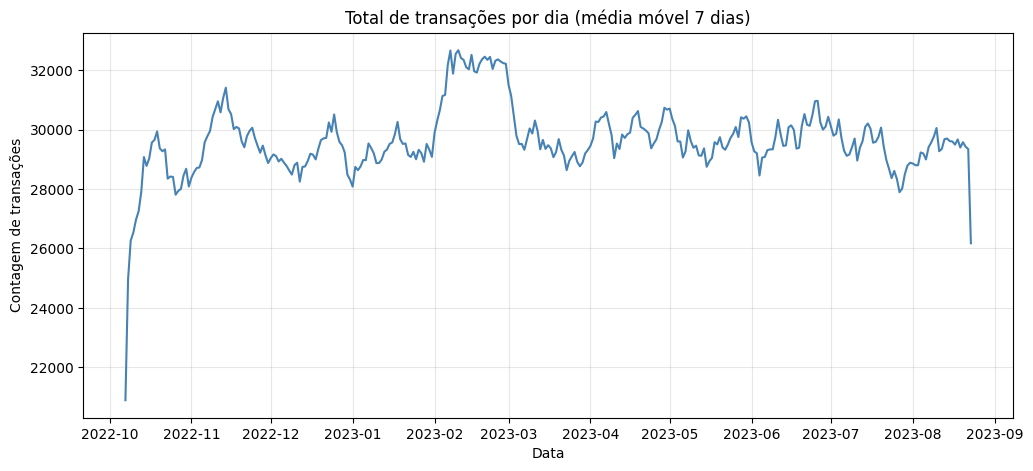

In [68]:
plt.figure(figsize=(12,5))
daily_total_smooth.plot(color='steelblue')
plt.title(f'Total de transações por dia (média móvel {ROLLING_DAYS} dias)')
plt.xlabel('Data')
plt.ylabel('Contagem de transações')
plt.grid(alpha=0.3)
plt.show()

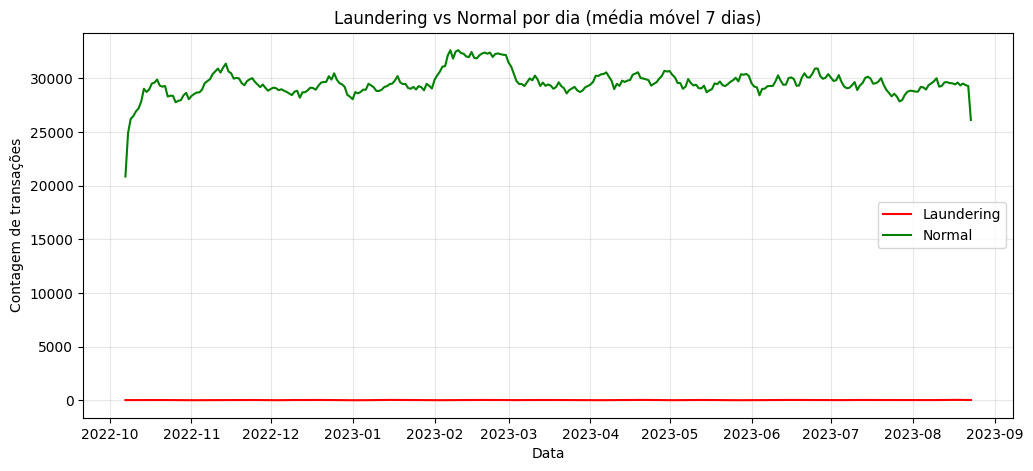

In [69]:
plt.figure(figsize=(12,5))
daily_laundering_smooth.plot(label='Laundering', color='red')
daily_normal_smooth.plot(label='Normal', color='green')
plt.title(f'Laundering vs Normal por dia (média móvel {ROLLING_DAYS} dias)')
plt.xlabel('Data')
plt.ylabel('Contagem de transações')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Isso só mostra como o dataset é muito desbalanceado

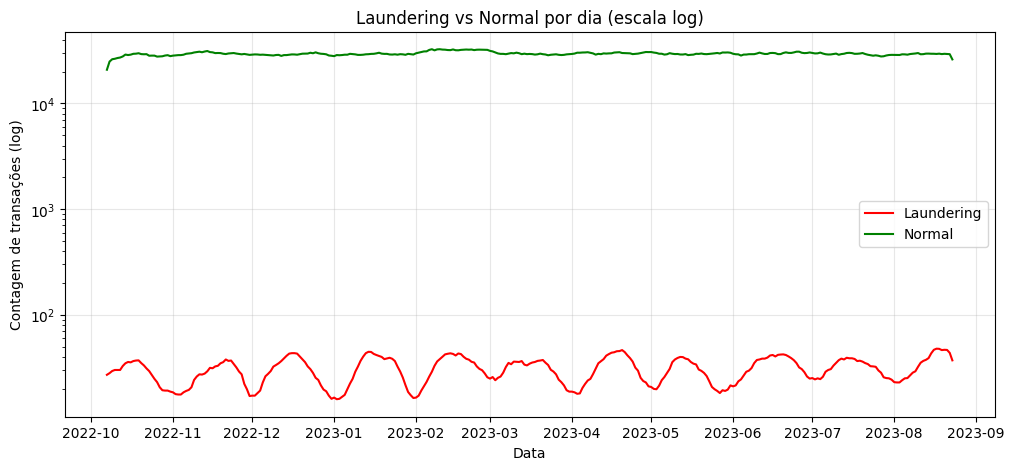

In [72]:
#usar log para que esses valores pequenos fiquem visíveis mesmo com essa diferença enorme
plt.figure(figsize=(12,5))
daily_laundering_smooth.plot(label='Laundering', color='red')
daily_normal_smooth.plot(label='Normal', color='green')
plt.yscale('log')
plt.title('Laundering vs Normal por dia (escala log)')
plt.xlabel('Data')
plt.ylabel('Contagem de transações (log)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

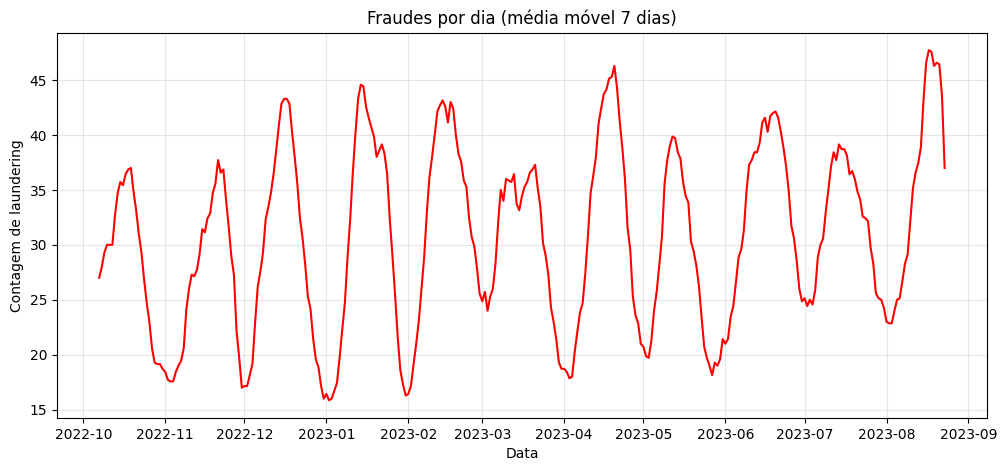

In [73]:
plt.figure(figsize=(12,5))
daily_laundering_smooth.plot(label='Laundering', color='red')
plt.title('Fraudes por dia (média móvel 7 dias)')
plt.xlabel('Data')
plt.ylabel('Contagem de laundering')
plt.grid(alpha=0.3)
plt.show()